### Neural Network student performace

- I denne filen kommer jeg til å ta for meg trening og tuning av neural network klasifikasjon for student performace datasettet. Jeg kommer til å bruke tensorflow keras Sequential og Model med og uten et dropoutlayer og sammelige hvilke av disse alternativere som prestere best.

- Siden deler av kommentarene i denne oppgaven vil være gjeldene for alle delene av oblig3 og 4 vil jeg skrive de samme eller veldig like kommentarer der hvor dette er hensiktsmessig i alle filene for disse oppgavene, men tilføre videre spesifikke kommentarer for den enkelte filen/oppgaven der hvor dette er hensiktsmessig.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import make_scorer, get_scorer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.optimizers import Adam, RMSprop
from scikeras.wrappers import KerasClassifier

In [2]:
df = pd.read_csv(r"..\..\oblig3_og_4\student_performance.csv", delimiter=";")

In [3]:
targets = pd.Series(np.array(LabelEncoder().fit_transform(df['Target'])))
features = pd.DataFrame(StandardScaler().fit_transform(df.drop('Target', axis=1)), columns=df.drop('Target', axis=1).columns)

In [4]:
global_random_state = 15

scoring = {
    'accuracy': get_scorer('accuracy'),
    'precision': make_scorer(precision_score, average='macro', zero_division=1.0),
    'recall': make_scorer(recall_score, average='macro', zero_division=1.0),
    'f1': make_scorer(f1_score, average='macro'), 
}

def evaluate(estimator, X, y):
    scores = {}
    for (name,scorer) in scoring.items():
        scores[name] = scorer(estimator, X, y) 
    return scores

def train(features, targets, estimator, params, scoring=scoring, refit='f1', random_state=global_random_state, outer_splits=5, inner_splits=4):

    outer_cv = StratifiedKFold(n_splits=outer_splits, shuffle=True, random_state=global_random_state)
    inner_cv = StratifiedKFold(n_splits=inner_splits, shuffle=True, random_state=global_random_state)

    scores_train = []
    scores_test = []
    estimators = []
    cv_results = []

    for (train_index, test_index) in outer_cv.split(features, targets):
        
        grid = GridSearchCV(
            estimator,
            params, 
            scoring=scoring, 
            refit=refit,
            error_score='raise', 
            cv=inner_cv)
        grid.fit(features.iloc[train_index], targets.iloc[train_index])        
        
        evaluation_train = evaluate(grid, features.iloc[train_index], targets.iloc[train_index])
        evaluation_test = evaluate(grid, features.iloc[test_index], targets.iloc[test_index])
        
        scores_train.append(evaluation_train)
        scores_test.append(evaluation_test)
        
        estimators.append(grid.best_estimator_)
        cv_results.append(pd.DataFrame(grid.cv_results_))
        print("*")

    return estimators, pd.DataFrame(scores_train), pd.DataFrame(scores_test), pd.concat(cv_results, names=['test_split'], keys=range(outer_splits))

def print_estimators(estimators):
    for estimatior in estimators:
        print(estimatior)


#### Beskrivelser av metoder for trening, tuning og testing av datasettet
- For å test og tune modellene har jeg laget en nested CV funksjon som bruker GridSearchCV som den indre loopen. Ut av denne funksjonen så får vi returnert den beste modellen for hver runde av den ytere loopen, de tilhørende scoring resultatene for både train og test oppsplittingen, og resultatene fra selve GridSearchCV modellen, som blant annet kan brukes til å visualisere parameter tuningen.

- Grunnen til at jeg har valgt å bruke et slik oppsett er at dette tillater meg å trene og tune modellene på hele datasettet uten at modellen overfiter til datasettet som en helhet. Dette gjør at resultatene du får ut fra denne typen validering i større grad vil ha god overførings verdi til hele datasettet for videre bruk.

- Måten dette oppnås på er at datasettet i yter loopen blir delt opp i for eks. 5 deler hvor du bruker 4 av disse dele til trening av modellene og den siste delen til testing. I den indre loopen splitter du igjen opp testdelen av data settet i for eks. 4 deler, hvor da 3 av disse brukes til trening av modellen og 1 del til testing/validering. På denne måte får du benyttet hele datasettet til trening og validering av modellene uten at den enkelte test delen av datasettet har blitt brukt til trening av modellen i forbindelse med sin vurdering av prestasjonen til modellen.

- Jeg har også lagt inn fuksjonalitet for å kunne endre antall spliter i ytter og inner loopene for treningen av modelene, noe som er kan være veldig nytt for å kunne redusere kjøretiden til fuksjonen ved utprøving av forskjellige tuning parameter.

- For oppdelingen av datasettet har jeg bruk StratifiedKFold slik at det oppnå så lik som mulig fordeling av target klassene mellom de forskjellige oppsplittingene av datasettet.

- For å vurdere disse modellene har jeg valgt å bruke disse metricene Accuracy, Precision, Recall og F1-score. Jeg ønsket i utgangspunktet også å inkludere Roc_auc men jeg fikk noen problemer med å implemntere denne for keras modellene så jeg valgt å ikke da den med i denne vurderingen.

- Accuracy er et mål på hvor treffsikre prediksjonene er for hele datasettet. Precision er et mål på hvor godt modellen klarer å predikere positive representasjoner for den enkelte klassen målt opp mot det totale antallet positive prediksjoner. Recall er et mål på hvor godt modellen klarer å predikere positive repsentasjoner for den enkelte klassen målt opp mot det det faktiske antalle av positive representasjoner. F1-score er en samlet representasjon av precision og recall som balansere hverandre slik at du en god verdi på den enne av disse vil balanseres av den dårlig verdi på den andre.

- For precision, recall, og f1, er det imidlertid hvert å merke seg at disse metricene i utgangspunktet er laget for å vurdere binære klassifikasjoner og at derfor må disse vurderes enkeltvis og så samles, jeg har valgt å bruke et uvektet macro gjennomsnitt for å oppnå dette.

- For å unngå eksponentiell kjøretid ved tuningen av modellene kommer jeg til å dele opp tuningen i midre deler slik at kjøretiden blir lettere håndterbar. Utover dette kommer jeg til å gjennomføre noe videre tuning og testing av modellene som ikke vil være inkludert i de endelige fila av hensyn til å gjøre dokumentet mer oversiktig og lett forstålig, men jeg kommer til å dokumentere den helheltlige prossens slik at det mulig å se en rød tråd gjennom tuningen av modellene. 

#### Tensorflow Keras 

- Som første modell starter jeg med en Keras Sequential modell som har 3 hidden layers i tillegg til input og utput layer. 

-  For alle modellene komm jeg til å bruke softmax som aktiverings fuksjon for output layeret da det er denne som er bergnet for denne typen datasett. For loss function så bruks sparse categorical crossentropy da det er denne function som er riktig å bruke for klassifikasjons datasett med flere utput klasser og ikke et binært output.

- For tuningen av modellene kommer jeg til å fokusere på følgene verdier, aktiverings funksjon for hidden layers, optimizer ved compilering, antall nevroner for 1 og 2 hidden layer, batch size, learing rate for optimizer og dropout for de modellene som inkludere dropout layer.

- Videre kommer jeg til å tune optimizer, activation function og loss function først og i hovedsak beholde disse resultatene for tuning av resten av modellene da disse i stor grad påvirkes av selve datasettet. Jeg har valg å gjøre dette som et tidssparende tiltak da jeg mener dette fortsatt viser tilstrekkelig forståelse for tuningen av disse parameterne. Men i en reell situasjon vil jeg selvfølgelig tune disse parameterne mer utfyllende for alle modellen. Jeg kommer også til å bruke samme fremgang måte for andre parametere for de modellene hvor jeg kun legger til dropout layer uten å endre modellen noe videre enn det.

- Jeg har gjort en grunnleggen sjekk i forkant sli at tuning verdiene jeg starter ikke er for langt unna jeg som blir slutt resultatet. Jeg valg å gjøre dette da parametere som er veldig ulik slutt resultat vil kunne påvirker resultatet for tuningene av de forskjellige parameterene. 

- Det kunne selfølgelig vært implementert endre mere utfylende tuning og utprøving av antall hidden layers, forskjellige activation functions for de individuelle hidden layers osv. Men jeg har valgt å begrense tuningen min til det utvalget jeg har gjort ut fra tidshensyn og det totale omfanget, da jeg mener at dette tilstrekkelig demonstere god forståelse for tuning prosessen og hvilke mulighet det er og hvilke hensyn som bør tas.  

In [15]:
def create_model(optimizer='adam', activation='swish', hidden_neurons=75, layers=2, dropout=0.1, reduction_factor=0.5, learning_rate=0.001):
    model = Sequential()
    model.add(Input(shape=(36,)))   
    model.add(Dense(hidden_neurons, activation=activation))    
    for layer in range(0, layers+1):
        hidden_neurons = int(hidden_neurons*reduction_factor)
        if(hidden_neurons >= 3):            
            model.add(Dense(hidden_neurons, activation=activation))
    if(dropout > 0):
        model.add(Dropout(dropout))
    model.add(Dense(3, activation='softmax'))
    if(optimizer == 'adam'):
        optimizer = Adam(learning_rate=learning_rate)
    else:
        optimizer = RMSprop(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model
keras_sequential_1 = KerasClassifier(model=create_model, verbose=0)

In [43]:
keras_class_param = {
    'batch_size': [10],
    'epochs': [10],
    'model__hidden_neurons': [75],
    'model__layers': [2],
    'model__reduction_factor': [0.5],
    'model__optimizer': ['adam', 'rmsprop'],
    'model__activation': ['relu', 'elu', 'swish'],
    'model__learning_rate': [0.0001, 0.001, 0.01],
    'model__dropout':[0],
}
keras_estimators_1, keras_scores_train_1, keras_scores_test_1, keras_cv_results_1 = train(features, targets, keras_sequential_1, keras_class_param, outer_splits=3, inner_splits=3)

*
*
*


NameError: name 'keras_cv_results_1' is not defined

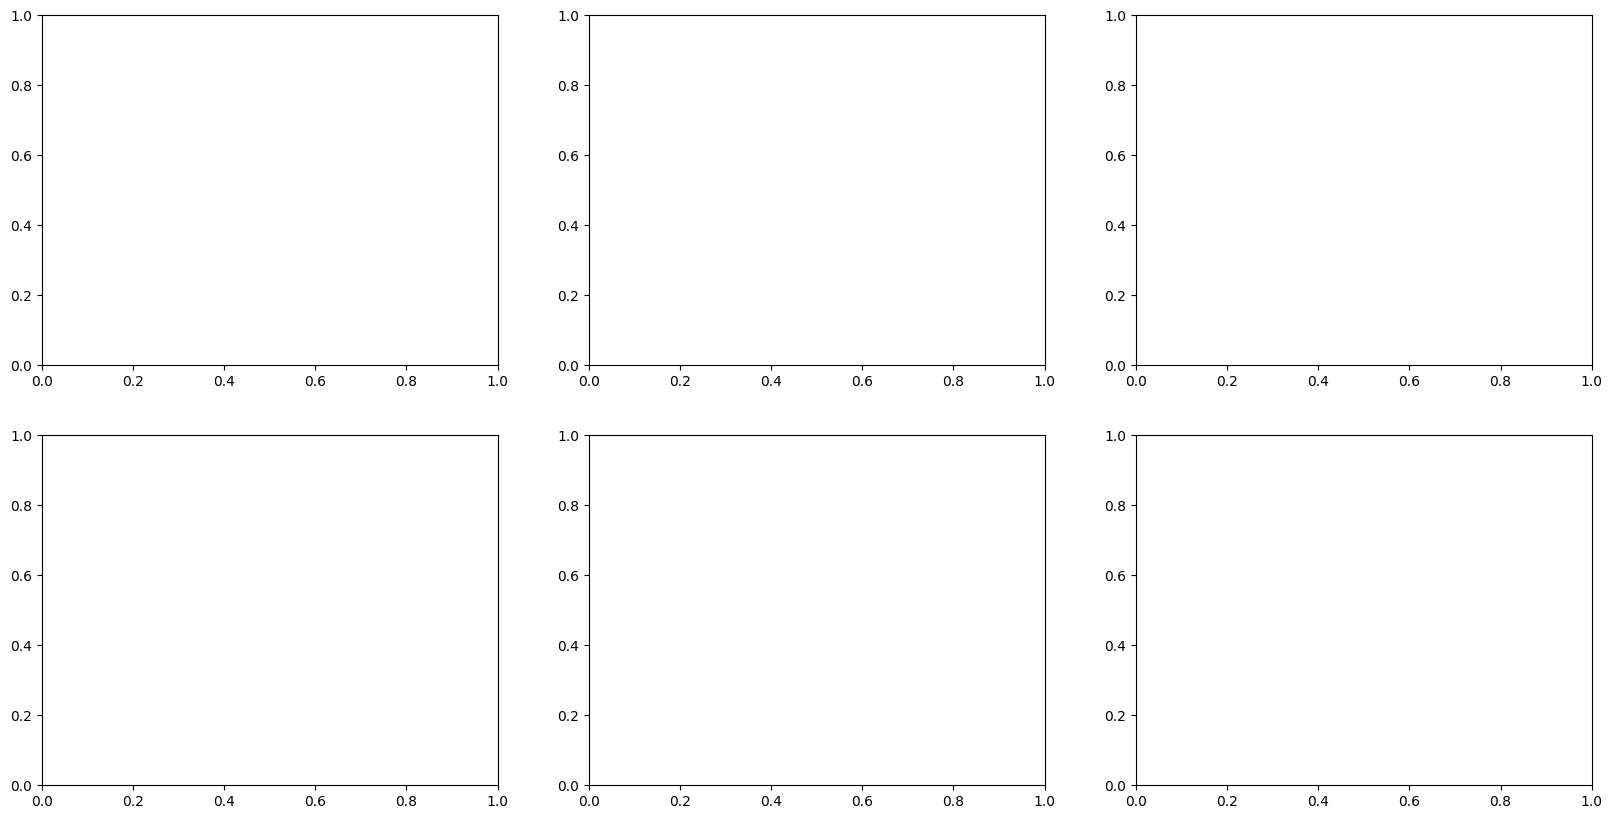

In [13]:
fig, ax = plt.subplots(2,3, figsize=(20,10))
sb.boxplot(data=keras_cv_results_1, x='param_model__optimizer', y='mean_test_accuracy', ax=ax[0, 0])
sb.boxplot(data=keras_cv_results_1, x='param_model__activation', y='mean_test_accuracy', ax=ax[0, 1])
sb.boxplot(data=keras_cv_results_1, x='param_model__learning_rate', y='mean_test_accuracy', ax=ax[0, 2])
sb.boxplot(data=keras_cv_results_1, x='param_model__optimizer', y='mean_test_f1', ax=ax[1,0])
sb.boxplot(data=keras_cv_results_1, x='param_model__activation', y='mean_test_f1', ax=ax[1,1])
sb.boxplot(data=keras_cv_results_1, x='param_model__learning_rate', y='mean_test_f1', ax=ax[1,2])

In [16]:
keras_class_param = {
    'batch_size': [10],
    'epochs': [10],
    'model__hidden_neurons': [35, 75, 150], 
    'model__layers': [2, 5, 10], 
    'model__reduction_factor': [0.3, 0.5, 0.7],
    'model__optimizer': ['adam'],
    'model__activation': ['elu'],
    'model__learning_rate': [0.001],
    'model__dropout':[0],
}
keras_estimators_2, keras_scores_train_2, keras_scores_test_2, keras_cv_results_2 = train(features, targets, keras_sequential_1, keras_class_param, outer_splits=3, inner_splits=3)

*
*
*


<Axes: xlabel='param_model__dropout', ylabel='mean_test_f1'>

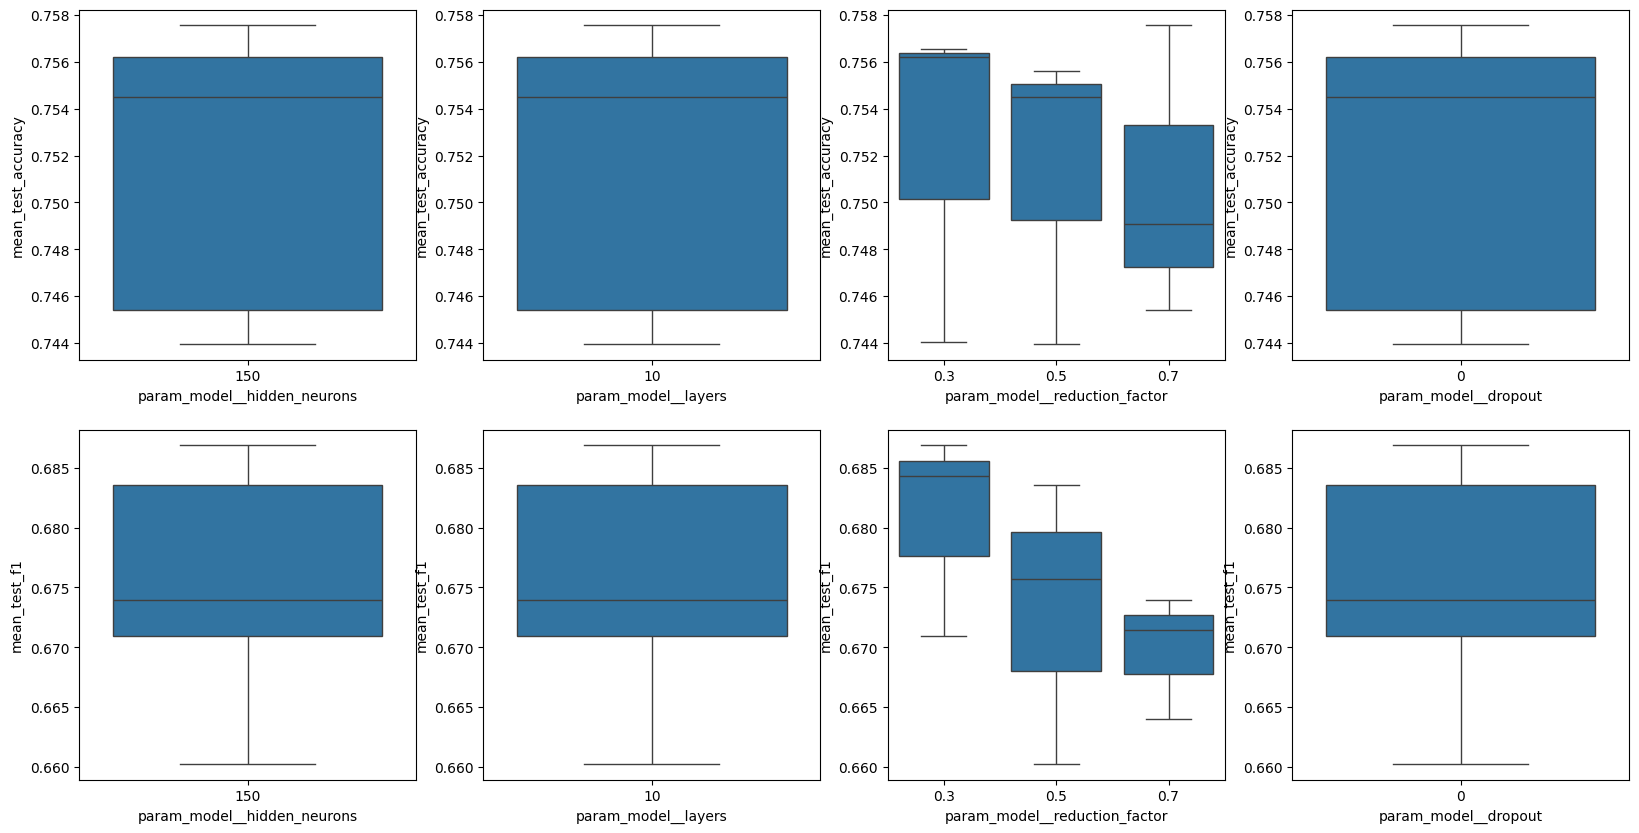

In [17]:
fig, ax = plt.subplots(2,4, figsize=(20,10))
sb.boxplot(data=keras_cv_results_2, x='param_model__hidden_neurons', y='mean_test_accuracy', ax=ax[0, 0])
sb.boxplot(data=keras_cv_results_2, x='param_model__layers', y='mean_test_accuracy', ax=ax[0, 1])
sb.boxplot(data=keras_cv_results_2, x='param_model__reduction_factor', y='mean_test_accuracy', ax=ax[0, 2])
sb.boxplot(data=keras_cv_results_2, x='param_model__dropout', y='mean_test_accuracy', ax=ax[0, 3])
sb.boxplot(data=keras_cv_results_2, x='param_model__hidden_neurons', y='mean_test_f1', ax=ax[1,0])
sb.boxplot(data=keras_cv_results_2, x='param_model__layers', y='mean_test_f1', ax=ax[1,1])
sb.boxplot(data=keras_cv_results_2, x='param_model__reduction_factor', y='mean_test_f1', ax=ax[1,2])
sb.boxplot(data=keras_cv_results_2, x='param_model__dropout', y='mean_test_f1', ax=ax[1,3])


In [70]:
keras_class_param = {
    'batch_size': [5, 10, 25],
    'epochs': [5, 10 , 20],
    'model__hidden_neurons': [20, 35, 75],
    'model__layers': [2],
    'model__reduction_factor': [0.3],
    'model__optimizer': ['adam'],
    'model__activation': ['elu'],
    'model__learning_rate': [0.001],
    'model__dropout':[0, 0.1],
}
keras_estimators_3, keras_scores_train_3, keras_scores_test_3, keras_cv_results_3 = train(features, targets, keras_sequential_1, keras_class_param, outer_splits=3, inner_splits=3)

*
*
*


<Axes: xlabel='param_model__dropout', ylabel='mean_test_f1'>

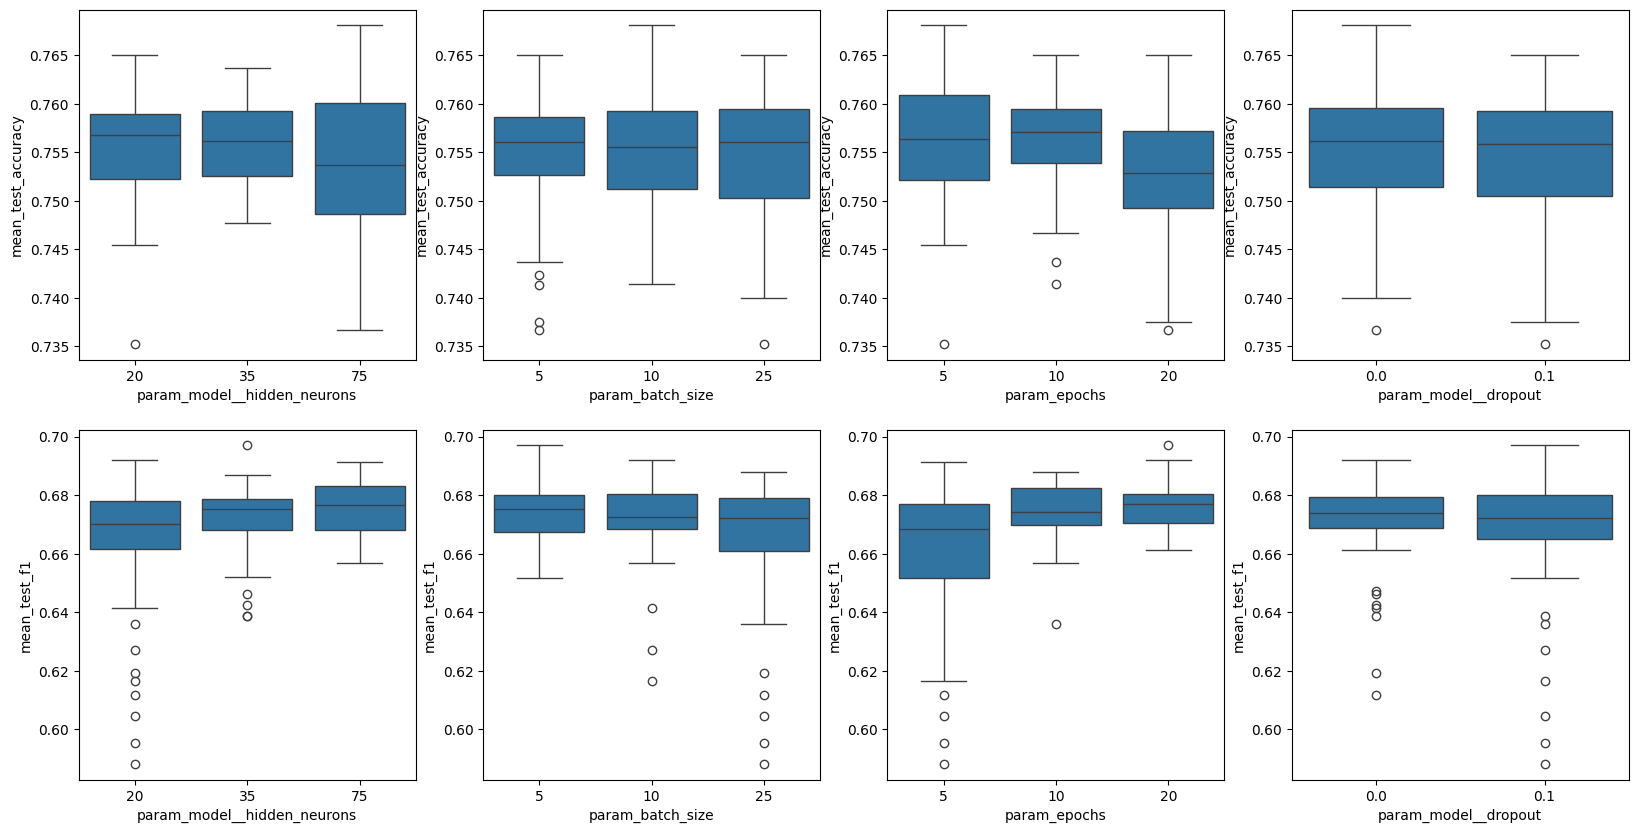

In [71]:
fig, ax = plt.subplots(2,4, figsize=(20,10))
sb.boxplot(data=keras_cv_results_3, x='param_model__hidden_neurons', y='mean_test_accuracy', ax=ax[0, 0])
sb.boxplot(data=keras_cv_results_3, x='param_batch_size', y='mean_test_accuracy', ax=ax[0, 1])
sb.boxplot(data=keras_cv_results_3, x='param_epochs', y='mean_test_accuracy', ax=ax[0, 2])
sb.boxplot(data=keras_cv_results_3, x='param_model__dropout', y='mean_test_accuracy', ax=ax[0, 3])
sb.boxplot(data=keras_cv_results_3, x='param_model__hidden_neurons', y='mean_test_f1', ax=ax[1,0])
sb.boxplot(data=keras_cv_results_3, x='param_batch_size', y='mean_test_f1', ax=ax[1,1])
sb.boxplot(data=keras_cv_results_3, x='param_epochs', y='mean_test_f1', ax=ax[1,2])
sb.boxplot(data=keras_cv_results_3, x='param_model__dropout', y='mean_test_f1', ax=ax[1,3])

In [ ]:
def create_model_2(optimizer='adam', activation='swish', hidden_neurons=75, layers=2, dropout=0.1, reduction_factor=0.5, learning_rate=0.001):
    input = Input(shape=(36,))
    x = (Dense(hidden_neurons, activation=activation))(input)
    if(layers > 0):
        hidden_neurons = hidden_neurons*reduction_factor
        if(hidden_neurons >= 1):
            x = (Dense(int(hidden_neurons), activation=activation))(x) + (Dense(int(hidden_neurons), activation=activation))(x)     
    if(layers > 1):
        hidden_neurons = hidden_neurons*reduction_factor
        if(hidden_neurons >= 1):
            x = (Dense(int(hidden_neurons), activation=activation))(x) + (Dense(int(hidden_neurons), activation=activation))(input)
    if(dropout > 0):
        x = (Dropout(dropout))(x)
    x = (Dense(3, activation='softmax'))(x)
    model = Model(inputs=input, outputs=x)   
    if(optimizer == 'adam'):
        optimizer = Adam(learning_rate=learning_rate)
    else:
        optimizer = RMSprop(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model
keras_model = KerasClassifier(model=create_model_2, verbose=0)

In [73]:
keras_class_param = {
    'batch_size': [10],
    'epochs': [10],
    'model__hidden_neurons': [35, 75, 150],
    'model__layers': [0, 1, 2],
    'model__reduction_factor': [0.3 ,0.5, 0.7],
    'model__optimizer': ['adam'],
    'model__activation': ['elu'],
    'model__learning_rate': [0.001],
    'model__dropout':[0, 0.1],
}
keras_estimators_4, keras_scores_train_4, keras_scores_test_4, keras_cv_results_4 = train(features, targets, keras_model, keras_class_param, outer_splits=3, inner_splits=3)

KeyboardInterrupt: 

In [25]:
def create_model(optimizer="adam", loss='sparse_categorical_crossentropy', activation='relu', hidden_neurons1=144, hidden_neurons2=72):
    model = Sequential()
    model.add(Input(shape=(36,)))
    model.add(Dense(hidden_neurons1, activation=activation))
    if(hidden_neurons2 > 0):
        model.add(Dense(hidden_neurons2, activation=activation))
    model.add(Dense(12, activation=activation))
    model.add(Dense(3, activation='softmax'))
    model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
    return model
keras_sequential = KerasClassifier(model=create_model, verbose=0)

In [ ]:
keras_class_param = {
    'batch_size': [20],
    'epochs': [10],
    'model__hidden_neurons1': [144],     
    'model__optimizer': ['adam', 'sgd', 'rmsprop'],
    'model__activation': ['relu', 'tanh', 'elu', 'swish'],
}
keras_estimators, keras_scores_train, keras_scores_test, keras_cv_results = train(features, targets, keras_sequential, keras_class_param, outer_splits=3, inner_splits=3)

*
*
*


<Axes: xlabel='param_model__activation', ylabel='mean_test_f1'>

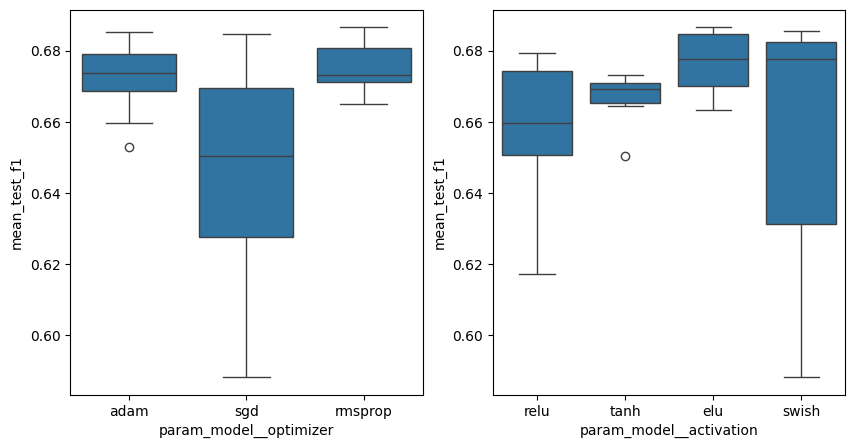

In [8]:
fig, ax = plt.subplots(1,2, figsize=(10,5))
sb.boxplot(data=keras_cv_results, x='param_model__optimizer', y='mean_test_f1', ax=ax[0])
sb.boxplot(data=keras_cv_results, x='param_model__activation', y='mean_test_f1', ax=ax[1])


In [9]:
keras_scores_test.describe()

,accuracy,precision,recall,f1
count,3.000000,3.000000,3.000000,3.000000
mean,0.764919,0.706333,0.677857,0.685925
std,0.001349,0.004395,0.003081,0.002790
min,0.763390,0.701268,0.674303,0.683934
25%,0.764407,0.704933,0.676904,0.684331
50%,0.765424,0.708598,0.679506,0.684728
75%,0.765683,0.708866,0.679635,0.686921
max,0.765943,0.709134,0.679764,0.689114


In [10]:
keras_scores_train.describe()

,accuracy,precision,recall,f1
count,3.000000,3.000000,3.000000,3.000000
mean,0.823915,0.795569,0.752304,0.766979
std,0.006871,0.005925,0.011605,0.009970
min,0.819261,0.792074,0.742683,0.758842
25%,0.819969,0.792148,0.745859,0.761418
50%,0.820678,0.792223,0.749035,0.763994
75%,0.826243,0.797316,0.757114,0.771047
max,0.831807,0.802410,0.765193,0.778100


In [169]:
keras_estimators

[KerasClassifier(
 	model=<function create_model at 0x000002350AD29E40>
 	build_fn=None
 	warm_start=False
 	random_state=None
 	optimizer=rmsprop
 	loss=None
 	metrics=None
 	batch_size=20
 	validation_batch_size=None
 	verbose=0
 	callbacks=None
 	validation_split=0.0
 	shuffle=True
 	run_eagerly=False
 	epochs=10
 	class_weight=None
 	model__activation=elu
 	model__hidden_neurons1=144
 	model__hidden_neurons2=72
 	model__optimizer=rmsprop
 ),
 KerasClassifier(
 	model=<function create_model at 0x000002350AD29E40>
 	build_fn=None
 	warm_start=False
 	random_state=None
 	optimizer=rmsprop
 	loss=None
 	metrics=None
 	batch_size=20
 	validation_batch_size=None
 	verbose=0
 	callbacks=None
 	validation_split=0.0
 	shuffle=True
 	run_eagerly=False
 	epochs=10
 	class_weight=None
 	model__activation=swish
 	model__hidden_neurons1=144
 	model__hidden_neurons2=72
 	model__optimizer=adam
 ),
 KerasClassifier(
 	model=<function create_model at 0x000002350AD29E40>
 	build_fn=None
 	warm_start=

In [12]:
keras_class_param = {
    'batch_size': [20],
    'epochs': [10],
    'model__hidden_neurons1': [108, 144, 180],
    'model__hidden_neurons2': [72],      
    'model__optimizer': ['adam', 'rmsprop'],
    'model__activation': ['relu', 'elu', 'swish'],
}
keras_estimators_2, keras_scores_train_2, keras_scores_test_2, keras_cv_results_2 = train(features, targets, keras_sequential, keras_class_param, outer_splits=5, inner_splits=4)

*
*
*
*
*


<Axes: xlabel='param_model__activation', ylabel='mean_test_f1'>

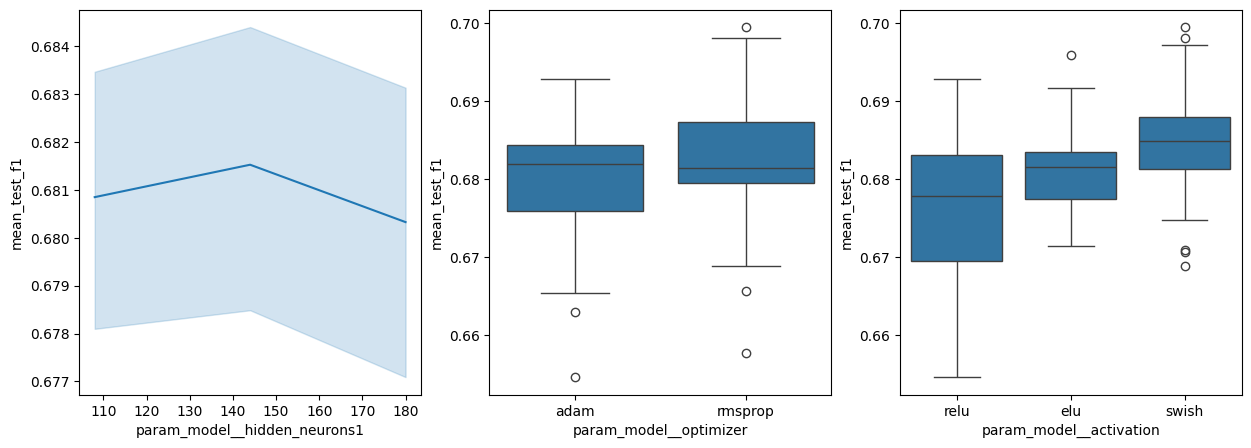

In [13]:
fig, ax = plt.subplots(1,3, figsize=(15,5))
sb.lineplot(data=keras_cv_results_2, x='param_model__hidden_neurons1', y='mean_test_f1', ax=ax[0])
sb.boxplot(data=keras_cv_results_2, x='param_model__optimizer', y='mean_test_f1', ax=ax[1])
sb.boxplot(data=keras_cv_results_2, x='param_model__activation', y='mean_test_f1', ax=ax[2])

In [14]:
keras_scores_test_2.describe()

,accuracy,precision,recall,f1
count,5.000000,5.000000,5.000000,5.000000
mean,0.761979,0.702489,0.675901,0.682652
std,0.007968,0.010372,0.007676,0.008314
min,0.750282,0.687853,0.665457,0.670964
25%,0.757919,0.697079,0.672993,0.678507
50%,0.764972,0.703701,0.676767,0.684730
75%,0.766102,0.709904,0.677704,0.686085
max,0.770621,0.713906,0.686585,0.692975


In [15]:
keras_scores_train_2.describe()

,accuracy,precision,recall,f1
count,5.000000,5.000000,5.000000,5.000000
mean,0.823463,0.793742,0.753684,0.766882
std,0.016420,0.022725,0.027318,0.027618
min,0.806725,0.774882,0.719441,0.733043
25%,0.817514,0.782320,0.741149,0.756066
50%,0.818028,0.787721,0.751873,0.763030
75%,0.824527,0.790869,0.762623,0.773852
max,0.850523,0.832920,0.793335,0.808421


In [16]:
keras_estimators_2

[KerasClassifier(
 	model=<function create_model at 0x000002350AD29E40>
 	build_fn=None
 	warm_start=False
 	random_state=None
 	optimizer=rmsprop
 	loss=None
 	metrics=None
 	batch_size=20
 	validation_batch_size=None
 	verbose=0
 	callbacks=None
 	validation_split=0.0
 	shuffle=True
 	run_eagerly=False
 	epochs=10
 	class_weight=None
 	model__activation=elu
 	model__hidden_neurons1=180
 	model__hidden_neurons2=72
 	model__optimizer=adam
 ),
 KerasClassifier(
 	model=<function create_model at 0x000002350AD29E40>
 	build_fn=None
 	warm_start=False
 	random_state=None
 	optimizer=rmsprop
 	loss=None
 	metrics=None
 	batch_size=20
 	validation_batch_size=None
 	verbose=0
 	callbacks=None
 	validation_split=0.0
 	shuffle=True
 	run_eagerly=False
 	epochs=10
 	class_weight=None
 	model__activation=swish
 	model__hidden_neurons1=144
 	model__hidden_neurons2=72
 	model__optimizer=rmsprop
 ),
 KerasClassifier(
 	model=<function create_model at 0x000002350AD29E40>
 	build_fn=None
 	warm_start=

In [32]:
keras_class_param = {
    'batch_size': [5, 10, 20],
    'epochs': [10],
    'model__hidden_neurons1': [144],
    'model__hidden_neurons2': [36, 72, 108],      
    'model__optimizer': ['rmsprop'],
    'model__activation': ['swish'],
}
keras_estimators_3, keras_scores_train_3, keras_scores_test_3, keras_cv_results_3 = train(features, targets, keras_sequential, keras_class_param, outer_splits=5, inner_splits=4)

*
*
*
*
*


<Axes: xlabel='param_batch_size', ylabel='mean_test_f1'>

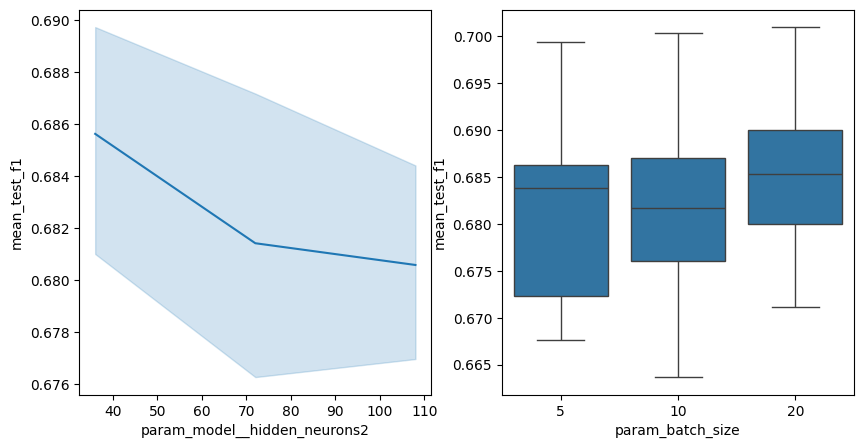

In [35]:
fig, ax = plt.subplots(1,2, figsize=(10,5))
sb.lineplot(data=keras_cv_results_3, x='param_model__hidden_neurons2', y='mean_test_f1', ax=ax[0])
sb.boxplot(data=keras_cv_results_3, x='param_batch_size', y='mean_test_f1', ax=ax[1])


In [36]:
keras_scores_test_3.describe()

,accuracy,precision,recall,f1
count,5.000000,5.000000,5.000000,5.000000
mean,0.761983,0.705402,0.680843,0.689062
std,0.011846,0.013616,0.012661,0.012611
min,0.745763,0.690440,0.662523,0.671918
25%,0.757062,0.698164,0.673429,0.681529
50%,0.760452,0.698681,0.685415,0.690287
75%,0.770621,0.718862,0.689724,0.698672
max,0.776018,0.720861,0.693125,0.702904


In [37]:
keras_scores_train_3.describe()

,accuracy,precision,recall,f1
count,5.000000,5.000000,5.000000,5.000000
mean,0.817812,0.783781,0.751266,0.763500
std,0.006948,0.012256,0.008423,0.009558
min,0.807573,0.765672,0.736839,0.747605
25%,0.814072,0.777291,0.752759,0.762691
50%,0.820621,0.788363,0.752789,0.766990
75%,0.821984,0.791625,0.755229,0.767601
max,0.824809,0.795955,0.758710,0.772616


In [41]:
keras_estimators_3

[KerasClassifier(
 	model=<function create_model at 0x00000237F986E520>
 	build_fn=None
 	warm_start=False
 	random_state=None
 	optimizer=rmsprop
 	loss=None
 	metrics=None
 	batch_size=20
 	validation_batch_size=None
 	verbose=0
 	callbacks=None
 	validation_split=0.0
 	shuffle=True
 	run_eagerly=False
 	epochs=10
 	class_weight=None
 	model__activation=swish
 	model__hidden_neurons1=144
 	model__hidden_neurons2=72
 	model__optimizer=rmsprop
 ),
 KerasClassifier(
 	model=<function create_model at 0x00000237F986E520>
 	build_fn=None
 	warm_start=False
 	random_state=None
 	optimizer=rmsprop
 	loss=None
 	metrics=None
 	batch_size=20
 	validation_batch_size=None
 	verbose=0
 	callbacks=None
 	validation_split=0.0
 	shuffle=True
 	run_eagerly=False
 	epochs=10
 	class_weight=None
 	model__activation=swish
 	model__hidden_neurons1=144
 	model__hidden_neurons2=108
 	model__optimizer=rmsprop
 ),
 KerasClassifier(
 	model=<function create_model at 0x00000237F986E520>
 	build_fn=None
 	warm_

In [26]:
def create_model_2(loss='sparse_categorical_crossentropy', activation='swish', hidden_neurons1=144, hidden_neurons2=72, learing_rate=0.001):
    model = Sequential()
    model.add(Input(shape=(36,)))
    model.add(Dense(hidden_neurons1, activation=activation))
    if(hidden_neurons2 > 0):
        model.add(Dense(hidden_neurons2, activation=activation))
    model.add(Dense(12, activation=activation))
    model.add(Dense(3, activation='softmax'))
    model.compile(optimizer=RMSprop(learning_rate=learing_rate), loss=loss, metrics=['accuracy'])
    return model
keras_sequential_2 = KerasClassifier(model=create_model_2, verbose=0)

In [ ]:
keras_class_param = {
    'batch_size': [20, 30],
    'epochs': [10],
    'model__hidden_neurons1': [144],
    'model__hidden_neurons2': [36],
    'model__activation': ['swish'],
    'model__learing_rate': [0.0001, 0.0005, 0.001, 0.01],
}
keras_estimators_4, keras_scores_train_4, keras_scores_test_4, keras_cv_results_4 = train(features, targets, keras_sequential_2, keras_class_param, outer_splits=5, inner_splits=4)

*
*
*
*
*


<Axes: xlabel='param_model__learing_rate', ylabel='mean_test_f1'>

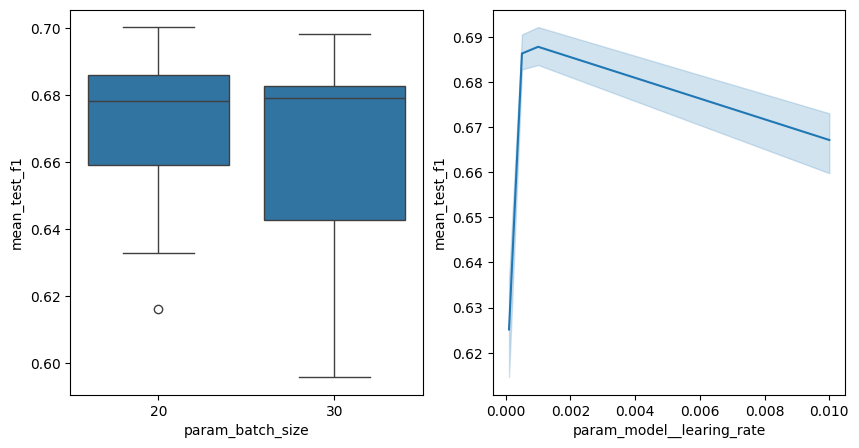

In [56]:
fig, ax = plt.subplots(1,2, figsize=(10,5))
sb.boxplot(data=keras_cv_results_4, x='param_batch_size', y='mean_test_f1', ax=ax[0])
sb.lineplot(data=keras_cv_results_4, x='param_model__learing_rate', y='mean_test_f1', ax=ax[1])


In [57]:
keras_scores_test_4.describe()

,accuracy,precision,recall,f1
count,5.000000,5.000000,5.000000,5.000000
mean,0.768536,0.715220,0.685098,0.694164
std,0.011468,0.013315,0.012615,0.012105
min,0.750282,0.699660,0.665959,0.676718
25%,0.768362,0.711036,0.682822,0.691593
50%,0.770362,0.711105,0.683586,0.691777
75%,0.771751,0.718550,0.696556,0.702328
max,0.781921,0.735751,0.696567,0.708405


In [59]:
keras_scores_train_4.describe()

,accuracy,precision,recall,f1
count,5.000000,5.000000,5.000000,5.000000
mean,0.807244,0.769024,0.732148,0.744617
std,0.010326,0.015003,0.016047,0.016213
min,0.792314,0.747339,0.707925,0.719712
25%,0.802487,0.761994,0.723573,0.736612
50%,0.809551,0.772191,0.740645,0.753735
75%,0.812429,0.777092,0.743224,0.755822
max,0.819441,0.786503,0.745372,0.757203


In [61]:
keras_estimators_4

[KerasClassifier(
 	model=<function create_model_2 at 0x00000238BBF43CE0>
 	build_fn=None
 	warm_start=False
 	random_state=None
 	optimizer=rmsprop
 	loss=None
 	metrics=None
 	batch_size=20
 	validation_batch_size=None
 	verbose=0
 	callbacks=None
 	validation_split=0.0
 	shuffle=True
 	run_eagerly=False
 	epochs=10
 	class_weight=None
 	model__activation=swish
 	model__hidden_neurons1=144
 	model__hidden_neurons2=36
 	model__learing_rate=0.001
 ),
 KerasClassifier(
 	model=<function create_model_2 at 0x00000238BBF43CE0>
 	build_fn=None
 	warm_start=False
 	random_state=None
 	optimizer=rmsprop
 	loss=None
 	metrics=None
 	batch_size=20
 	validation_batch_size=None
 	verbose=0
 	callbacks=None
 	validation_split=0.0
 	shuffle=True
 	run_eagerly=False
 	epochs=10
 	class_weight=None
 	model__activation=swish
 	model__hidden_neurons1=144
 	model__hidden_neurons2=36
 	model__learing_rate=0.0005
 ),
 KerasClassifier(
 	model=<function create_model_2 at 0x00000238BBF43CE0>
 	build_fn=None

In [27]:
keras_class_param = {
    'batch_size': [10],
    'epochs': [10],
    'model__hidden_neurons1': [144],
    'model__hidden_neurons2': [36],
    'model__activation': ['swish'],
    'model__learing_rate': [0.001],
}
keras_sequential_estimators_final, keras_sequential_scores_train_final, keras_sequential_scores_test_final, keras_sequential_cv_results_final = train(features, targets, keras_sequential_2, keras_class_param, outer_splits=5, inner_splits=4)

*
*
*
*
*


In [63]:
keras_sequential_scores_test_final.describe()

,accuracy,precision,recall,f1
count,5.000000,5.000000,5.000000,5.000000
mean,0.766500,0.712294,0.678364,0.687600
std,0.005827,0.010568,0.008931,0.008512
min,0.758192,0.700921,0.669058,0.677345
25%,0.763575,0.702863,0.672230,0.681528
50%,0.767232,0.711969,0.676012,0.686918
75%,0.770621,0.721253,0.683327,0.694945
max,0.772881,0.724463,0.691195,0.697262


In [65]:
keras_sequential_scores_train_final.describe()

,accuracy,precision,recall,f1
count,5.000000,5.000000,5.000000,5.000000
mean,0.821146,0.793346,0.747592,0.762934
std,0.005463,0.008805,0.009914,0.010424
min,0.816050,0.786297,0.734837,0.750121
25%,0.817180,0.788761,0.743744,0.759174
50%,0.820571,0.788980,0.746126,0.760211
75%,0.822034,0.794550,0.751612,0.766986
max,0.829895,0.808141,0.761641,0.778180


In [28]:
def create_model_3(loss='sparse_categorical_crossentropy', activation='swish', hidden_neurons1=144, hidden_neurons2=36, dropout=0.1):
    model = Sequential()
    model.add(Input(shape=(36,)))
    model.add(Dense(hidden_neurons1, activation=activation))
    if(hidden_neurons2 > 0):
        model.add(Dense(hidden_neurons2, activation=activation))
    model.add(Dropout(dropout))
    model.add(Dense(12, activation=activation))
    model.add(Dense(3, activation='softmax'))
    model.compile(optimizer=RMSprop(learning_rate=0.0005), loss=loss, metrics=['accuracy'])
    return model
keras_sequential_dropout = KerasClassifier(model=create_model_3, verbose=0)

In [ ]:
keras_class_param = {
    'batch_size': [10],
    'epochs': [10],
    'model__activation': ['swish'],
    'model__dropout': [0.05, 0.1, 0.15, 0.2]
}
keras_estimators_6, keras_scores_train_6, keras_scores_test_6, keras_cv_results_6 = train(features, targets, keras_sequential_dropout, keras_class_param, outer_splits=5, inner_splits=4)

*
*
*
*
*


<Axes: xlabel='param_model__dropout', ylabel='mean_test_f1'>

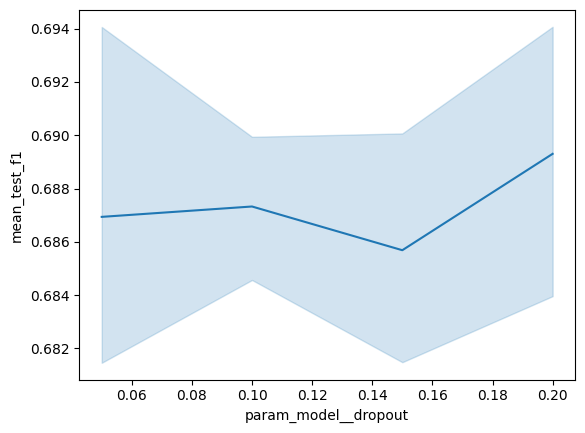

In [11]:
sb.lineplot(data=keras_cv_results_6, x='param_model__dropout', y='mean_test_f1')

In [9]:
keras_scores_test_6.describe()

,accuracy,precision,recall,f1
count,5.000000,5.000000,5.000000,5.000000
mean,0.767630,0.712716,0.683064,0.691550
std,0.012789,0.021540,0.015865,0.018526
min,0.754802,0.692747,0.671070,0.674045
25%,0.761582,0.699623,0.672467,0.683075
50%,0.764706,0.710209,0.676359,0.684486
75%,0.768362,0.712516,0.685952,0.693954
max,0.788701,0.748485,0.709471,0.722192


In [10]:
keras_scores_train_6.describe()

,accuracy,precision,recall,f1
count,5.000000,5.000000,5.000000,5.000000
mean,0.800520,0.757451,0.723704,0.734997
std,0.005815,0.006160,0.010578,0.009928
min,0.793727,0.749698,0.710399,0.722931
25%,0.794915,0.751973,0.715062,0.726058
50%,0.803617,0.761111,0.727264,0.739053
75%,0.803617,0.761116,0.730235,0.741392
max,0.806725,0.763355,0.735560,0.745553


In [13]:
keras_estimators_6

[KerasClassifier(
 	model=<function create_model_3 at 0x000002046D082DE0>
 	build_fn=None
 	warm_start=False
 	random_state=None
 	optimizer=rmsprop
 	loss=None
 	metrics=None
 	batch_size=10
 	validation_batch_size=None
 	verbose=0
 	callbacks=None
 	validation_split=0.0
 	shuffle=True
 	run_eagerly=False
 	epochs=10
 	class_weight=None
 	model__activation=swish
 	model__dropout=0.1
 ),
 KerasClassifier(
 	model=<function create_model_3 at 0x000002046D082DE0>
 	build_fn=None
 	warm_start=False
 	random_state=None
 	optimizer=rmsprop
 	loss=None
 	metrics=None
 	batch_size=10
 	validation_batch_size=None
 	verbose=0
 	callbacks=None
 	validation_split=0.0
 	shuffle=True
 	run_eagerly=False
 	epochs=10
 	class_weight=None
 	model__activation=swish
 	model__dropout=0.05
 ),
 KerasClassifier(
 	model=<function create_model_3 at 0x000002046D082DE0>
 	build_fn=None
 	warm_start=False
 	random_state=None
 	optimizer=rmsprop
 	loss=None
 	metrics=None
 	batch_size=10
 	validation_batch_size=N

In [29]:
keras_class_param = {
    'batch_size': [10],
    'epochs': [10],
    'model__activation': ['swish'],
    'model__dropout': [0.1]
}
keras_sequential_dropout_estimators_final, keras_sequential_dropout_scores_train_final, keras_sequential_dropout_scores_test_final, keras_sequential_dropout_cv_results_final = train(features, targets, keras_sequential_dropout, keras_class_param, outer_splits=5, inner_splits=4)

*
*
*
*
*


In [15]:
keras_sequential_dropout_scores_test_final.describe()

,accuracy,precision,recall,f1
count,5.000000,5.000000,5.000000,5.000000
mean,0.766953,0.711603,0.686033,0.694060
std,0.016131,0.017059,0.012128,0.012671
min,0.741243,0.686323,0.665966,0.673150
25%,0.765837,0.709072,0.684226,0.694296
50%,0.769492,0.711982,0.689517,0.695205
75%,0.772881,0.716886,0.694491,0.701271
max,0.785311,0.733751,0.695967,0.706375


In [16]:
keras_sequential_dropout_scores_train_final.describe()

,accuracy,precision,recall,f1
count,5.000000,5.000000,5.000000,5.000000
mean,0.802837,0.763372,0.732135,0.743011
std,0.002078,0.002338,0.009008,0.006717
min,0.800791,0.759708,0.719922,0.732722
25%,0.801130,0.762440,0.728205,0.741078
50%,0.802204,0.764482,0.731768,0.743728
75%,0.804747,0.764749,0.736956,0.747312
max,0.805312,0.765482,0.743822,0.750213


In [30]:
def create_model_4(loss='sparse_categorical_crossentropy', activation='swish', hidden_neurons1=144, hidden_neurons2=36):
    input = Input(shape=(36,))
    x = (Dense(hidden_neurons1, activation=activation))(input)
    x = (Dense(hidden_neurons2, activation=activation))(x) + (Dense(hidden_neurons2, activation=activation))(input)
    x = (Dense(12, activation=activation))(x)
    x = (Dense(3, activation='softmax'))(x)
    model = Model(inputs=input, outputs=x)
    model.compile(optimizer=Adam(learning_rate=0.0005), loss=loss, metrics=['accuracy'])
    return model
keras_model = KerasClassifier(model=create_model_4, verbose=0)

In [ ]:
keras_class_param = {
    'batch_size': [10],
    'epochs': [10],
    'model__hidden_neurons1': [108, 144, 180], 
    'model__hidden_neurons2': [24, 36, 48],
    'model__activation': ['swish'],
}
keras_estimators_7, keras_scores_train_7, keras_scores_test_7, keras_cv_results_7 = train(features, targets, keras_model, keras_class_param, outer_splits=5, inner_splits=4)

*
*
*
*
*


<Axes: xlabel='param_model__hidden_neurons2', ylabel='mean_test_f1'>

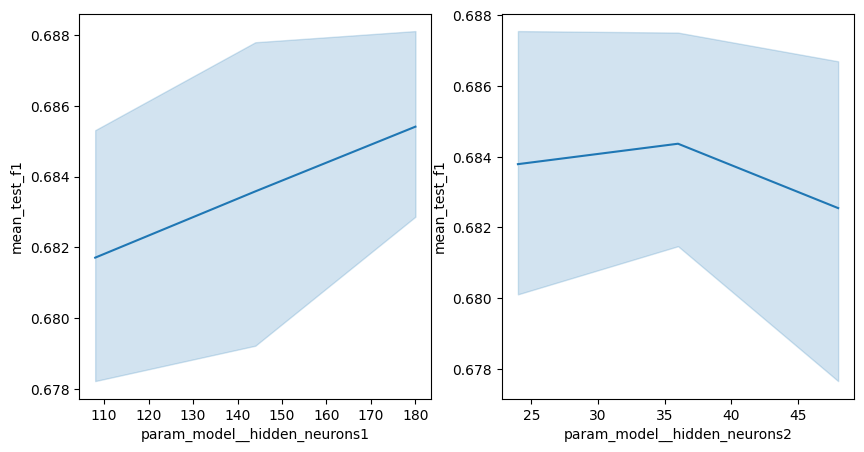

In [25]:
fig, ax = plt.subplots(1,2, figsize=(10,5))
sb.lineplot(data=keras_cv_results_7, x='param_model__hidden_neurons1', y='mean_test_f1', ax=ax[0])
sb.lineplot(data=keras_cv_results_7, x='param_model__hidden_neurons2', y='mean_test_f1', ax=ax[1])

In [26]:
keras_scores_test_7.describe()

,accuracy,precision,recall,f1
count,5.000000,5.000000,5.000000,5.000000
mean,0.767179,0.712945,0.680223,0.689801
std,0.012558,0.023495,0.017307,0.019930
min,0.746893,0.681679,0.652288,0.659039
25%,0.766968,0.705485,0.677945,0.686238
50%,0.768362,0.713685,0.684811,0.694695
75%,0.772881,0.716887,0.687419,0.695220
max,0.780791,0.746986,0.698654,0.713811


In [27]:
keras_scores_train_7.describe()

,accuracy,precision,recall,f1
count,5.000000,5.000000,5.000000,5.000000
mean,0.817134,0.786695,0.741704,0.756530
std,0.005958,0.011145,0.010864,0.011492
min,0.811529,0.779087,0.731282,0.746632
25%,0.813789,0.780236,0.736136,0.750485
50%,0.816332,0.782450,0.736698,0.751477
75%,0.816949,0.785566,0.745606,0.758433
max,0.827070,0.806136,0.758799,0.775623


In [57]:
keras_estimators_7

[KerasClassifier(
 	model=<function create_model_4 at 0x000002042C9A0F40>
 	build_fn=None
 	warm_start=False
 	random_state=None
 	optimizer=rmsprop
 	loss=None
 	metrics=None
 	batch_size=10
 	validation_batch_size=None
 	verbose=0
 	callbacks=None
 	validation_split=0.0
 	shuffle=True
 	run_eagerly=False
 	epochs=10
 	class_weight=None
 	model__activation=swish
 	model__hidden_neurons1=108
 	model__hidden_neurons2=48
 ),
 KerasClassifier(
 	model=<function create_model_4 at 0x000002042C9A0F40>
 	build_fn=None
 	warm_start=False
 	random_state=None
 	optimizer=rmsprop
 	loss=None
 	metrics=None
 	batch_size=10
 	validation_batch_size=None
 	verbose=0
 	callbacks=None
 	validation_split=0.0
 	shuffle=True
 	run_eagerly=False
 	epochs=10
 	class_weight=None
 	model__activation=swish
 	model__hidden_neurons1=144
 	model__hidden_neurons2=24
 ),
 KerasClassifier(
 	model=<function create_model_4 at 0x000002042C9A0F40>
 	build_fn=None
 	warm_start=False
 	random_state=None
 	optimizer=rmspr

In [32]:
keras_class_param = {
    'batch_size': [10],
    'epochs': [10],
    'model__hidden_neurons1': [144, 180, 224], 
    'model__hidden_neurons2': [48, 64],
    'model__activation': ['swish'],
}
keras_estimators_7_1, keras_scores_train_7_1, keras_scores_test_7_1, keras_cv_results_7_1 = train(features, targets, keras_model, keras_class_param, outer_splits=5, inner_splits=4)

*
*
*
*
*


<Axes: xlabel='param_model__hidden_neurons2', ylabel='mean_test_f1'>

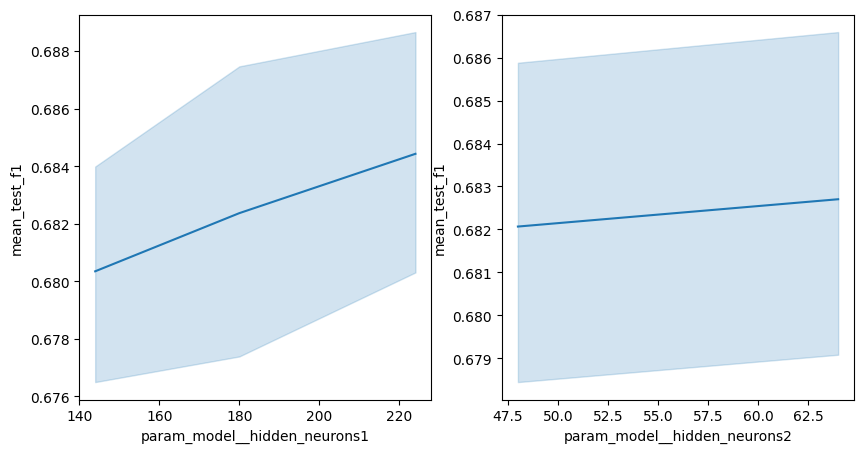

In [33]:
fig, ax = plt.subplots(1,2, figsize=(10,5))
sb.lineplot(data=keras_cv_results_7_1, x='param_model__hidden_neurons1', y='mean_test_f1', ax=ax[0])
sb.lineplot(data=keras_cv_results_7_1, x='param_model__hidden_neurons2', y='mean_test_f1', ax=ax[1])

In [36]:
keras_scores_test_7_1.describe()

,accuracy,precision,recall,f1
count,5.000000,5.000000,5.000000,5.000000
mean,0.762429,0.709503,0.687766,0.695499
std,0.012643,0.017939,0.020020,0.019644
min,0.748869,0.687388,0.661264,0.669728
25%,0.757062,0.702740,0.674511,0.683989
50%,0.761582,0.705680,0.694726,0.699308
75%,0.761582,0.715775,0.695833,0.702952
max,0.783051,0.735930,0.712495,0.721516


In [37]:
keras_scores_train_7_1.describe()

,accuracy,precision,recall,f1
count,5.000000,5.000000,5.000000,5.000000
mean,0.821316,0.788315,0.759600,0.770594
std,0.003009,0.006640,0.008709,0.007280
min,0.816949,0.782481,0.751073,0.763883
25%,0.819723,0.782597,0.752116,0.765544
50%,0.821984,0.786796,0.757594,0.767600
75%,0.823679,0.791544,0.766566,0.774530
max,0.824244,0.798157,0.770651,0.781412


In [39]:
keras_estimators_7_1

[KerasClassifier(
 	model=<function create_model_4 at 0x000002042C9A0F40>
 	build_fn=None
 	warm_start=False
 	random_state=None
 	optimizer=rmsprop
 	loss=None
 	metrics=None
 	batch_size=10
 	validation_batch_size=None
 	verbose=0
 	callbacks=None
 	validation_split=0.0
 	shuffle=True
 	run_eagerly=False
 	epochs=10
 	class_weight=None
 	model__activation=swish
 	model__hidden_neurons1=180
 	model__hidden_neurons2=48
 ),
 KerasClassifier(
 	model=<function create_model_4 at 0x000002042C9A0F40>
 	build_fn=None
 	warm_start=False
 	random_state=None
 	optimizer=rmsprop
 	loss=None
 	metrics=None
 	batch_size=10
 	validation_batch_size=None
 	verbose=0
 	callbacks=None
 	validation_split=0.0
 	shuffle=True
 	run_eagerly=False
 	epochs=10
 	class_weight=None
 	model__activation=swish
 	model__hidden_neurons1=224
 	model__hidden_neurons2=64
 ),
 KerasClassifier(
 	model=<function create_model_4 at 0x000002042C9A0F40>
 	build_fn=None
 	warm_start=False
 	random_state=None
 	optimizer=rmspr

In [40]:
keras_class_param = {
    'batch_size': [10],
    'epochs': [10],
    'model__hidden_neurons1': [224, 260, 300], 
    'model__hidden_neurons2': [64, 128],
    'model__activation': ['swish'],
}
keras_estimators_7_2, keras_scores_train_7_2, keras_scores_test_7_2, keras_cv_results_7_2 = train(features, targets, keras_model, keras_class_param, outer_splits=5, inner_splits=4)

*
*
*
*
*


<Axes: xlabel='param_model__hidden_neurons2', ylabel='mean_test_f1'>

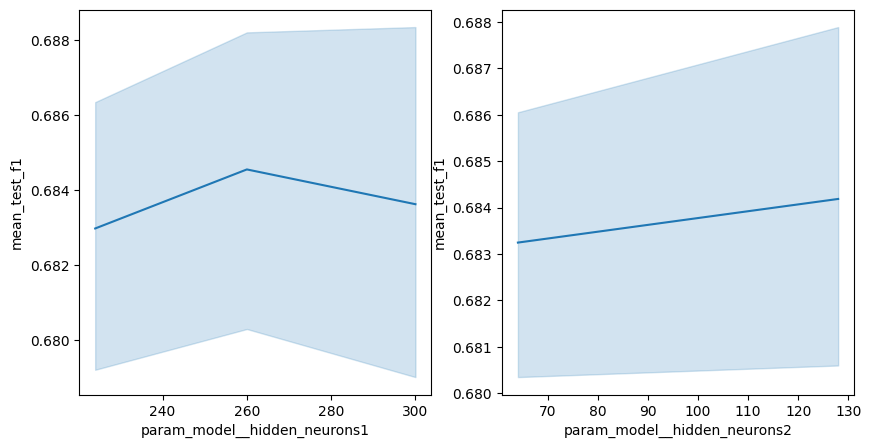

In [41]:
fig, ax = plt.subplots(1,2, figsize=(10,5))
sb.lineplot(data=keras_cv_results_7_2, x='param_model__hidden_neurons1', y='mean_test_f1', ax=ax[0])
sb.lineplot(data=keras_cv_results_7_2, x='param_model__hidden_neurons2', y='mean_test_f1', ax=ax[1])

In [42]:
keras_scores_test_7_2.describe()

,accuracy,precision,recall,f1
count,5.000000,5.000000,5.000000,5.000000
mean,0.762883,0.706906,0.683588,0.691576
std,0.008922,0.013164,0.009996,0.010885
min,0.750282,0.691301,0.672923,0.679724
25%,0.756787,0.696869,0.673127,0.680951
50%,0.767232,0.707705,0.687150,0.695784
75%,0.769492,0.714868,0.690190,0.696466
max,0.770621,0.723785,0.694553,0.704953


In [43]:
keras_scores_train_7_2.describe()

,accuracy,precision,recall,f1
count,5.000000,5.000000,5.000000,5.000000
mean,0.827871,0.797058,0.763284,0.775911
std,0.002619,0.004457,0.007728,0.006307
min,0.824527,0.793601,0.752766,0.767131
25%,0.826505,0.794025,0.758009,0.771307
50%,0.828200,0.795043,0.766390,0.779536
75%,0.828531,0.798303,0.767361,0.780631
max,0.831591,0.804317,0.771895,0.780950


In [46]:
keras_estimators_7_2

[KerasClassifier(
 	model=<function create_model_4 at 0x000002042C9A0F40>
 	build_fn=None
 	warm_start=False
 	random_state=None
 	optimizer=rmsprop
 	loss=None
 	metrics=None
 	batch_size=10
 	validation_batch_size=None
 	verbose=0
 	callbacks=None
 	validation_split=0.0
 	shuffle=True
 	run_eagerly=False
 	epochs=10
 	class_weight=None
 	model__activation=swish
 	model__hidden_neurons1=300
 	model__hidden_neurons2=128
 ),
 KerasClassifier(
 	model=<function create_model_4 at 0x000002042C9A0F40>
 	build_fn=None
 	warm_start=False
 	random_state=None
 	optimizer=rmsprop
 	loss=None
 	metrics=None
 	batch_size=10
 	validation_batch_size=None
 	verbose=0
 	callbacks=None
 	validation_split=0.0
 	shuffle=True
 	run_eagerly=False
 	epochs=10
 	class_weight=None
 	model__activation=swish
 	model__hidden_neurons1=300
 	model__hidden_neurons2=128
 ),
 KerasClassifier(
 	model=<function create_model_4 at 0x000002042C9A0F40>
 	build_fn=None
 	warm_start=False
 	random_state=None
 	optimizer=rms

In [48]:
keras_class_param = {
    'batch_size': [10],
    'epochs': [10],
    'model__hidden_neurons1': [144, 260], 
    'model__hidden_neurons2': [128, 160, 200],
    'model__activation': ['swish'],
}
keras_estimators_7_3, keras_scores_train_7_3, keras_scores_test_7_3, keras_cv_results_7_3 = train(features, targets, keras_model, keras_class_param, outer_splits=5, inner_splits=4)

*
*
*
*
*


<Axes: xlabel='param_model__hidden_neurons2', ylabel='mean_test_f1'>

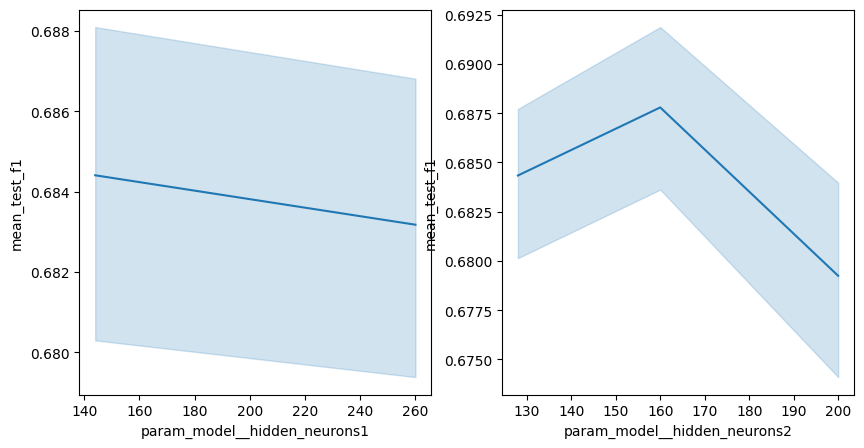

In [49]:
fig, ax = plt.subplots(1,2, figsize=(10,5))
sb.lineplot(data=keras_cv_results_7_3, x='param_model__hidden_neurons1', y='mean_test_f1', ax=ax[0])
sb.lineplot(data=keras_cv_results_7_3, x='param_model__hidden_neurons2', y='mean_test_f1', ax=ax[1])

In [50]:
keras_scores_test_7_3.describe()

,accuracy,precision,recall,f1
count,5.000000,5.000000,5.000000,5.000000
mean,0.761301,0.704761,0.676035,0.684464
std,0.007792,0.012883,0.018100,0.017444
min,0.749153,0.691069,0.656396,0.666403
25%,0.757919,0.694603,0.661584,0.669795
50%,0.764972,0.703723,0.679705,0.686577
75%,0.767232,0.711623,0.680295,0.689704
max,0.767232,0.722789,0.702194,0.709839


In [51]:
keras_scores_train_7_3.describe()

,accuracy,precision,recall,f1
count,5.000000,5.000000,5.000000,5.000000
mean,0.824198,0.798144,0.754425,0.769197
std,0.004890,0.009275,0.010952,0.009057
min,0.818310,0.786165,0.742645,0.756695
25%,0.822034,0.793027,0.748605,0.764682
50%,0.823679,0.797498,0.751719,0.769438
75%,0.825374,0.804130,0.757737,0.775282
max,0.831591,0.809897,0.771420,0.779890


In [53]:
keras_estimators_7_3

[KerasClassifier(
 	model=<function create_model_4 at 0x000002042C9A0F40>
 	build_fn=None
 	warm_start=False
 	random_state=None
 	optimizer=rmsprop
 	loss=None
 	metrics=None
 	batch_size=10
 	validation_batch_size=None
 	verbose=0
 	callbacks=None
 	validation_split=0.0
 	shuffle=True
 	run_eagerly=False
 	epochs=10
 	class_weight=None
 	model__activation=swish
 	model__hidden_neurons1=260
 	model__hidden_neurons2=160
 ),
 KerasClassifier(
 	model=<function create_model_4 at 0x000002042C9A0F40>
 	build_fn=None
 	warm_start=False
 	random_state=None
 	optimizer=rmsprop
 	loss=None
 	metrics=None
 	batch_size=10
 	validation_batch_size=None
 	verbose=0
 	callbacks=None
 	validation_split=0.0
 	shuffle=True
 	run_eagerly=False
 	epochs=10
 	class_weight=None
 	model__activation=swish
 	model__hidden_neurons1=260
 	model__hidden_neurons2=160
 ),
 KerasClassifier(
 	model=<function create_model_4 at 0x000002042C9A0F40>
 	build_fn=None
 	warm_start=False
 	random_state=None
 	optimizer=rms

In [31]:
keras_class_param = {
    'batch_size': [10],
    'epochs': [10],
    'model__hidden_neurons1': [144], 
    'model__hidden_neurons2': [48],
    'model__activation': ['swish'],
}
keras_model_estimators_final, keras_model_scores_train_final, keras_model_scores_test_final, keras_model_cv_results_final = train(features, targets, keras_model, keras_class_param, outer_splits=5, inner_splits=4)

*
*
*
*
*


In [59]:
keras_model_scores_test_final.describe()

,accuracy,precision,recall,f1
count,5.000000,5.000000,5.000000,5.000000
mean,0.767632,0.712767,0.686550,0.694989
std,0.009466,0.014125,0.011282,0.011804
min,0.758192,0.697865,0.676523,0.684670
25%,0.760452,0.702081,0.681716,0.690380
50%,0.764972,0.710644,0.683309,0.690909
75%,0.773756,0.720562,0.685333,0.693718
max,0.780791,0.732681,0.705870,0.715270


In [60]:
keras_model_scores_train_final.describe()

,accuracy,precision,recall,f1
count,5.000000,5.000000,5.000000,5.000000
mean,0.821768,0.788061,0.754337,0.766651
std,0.003151,0.005566,0.007246,0.006334
min,0.818310,0.779314,0.748104,0.761191
25%,0.819209,0.785792,0.750170,0.761546
50%,0.822266,0.790677,0.752091,0.765884
75%,0.822831,0.791990,0.754793,0.767855
max,0.826222,0.792533,0.766526,0.776779


In [32]:
def create_model_5(loss='sparse_categorical_crossentropy', activation='swish', hidden_neurons1=144, hidden_neurons2=36, dropout=0.1):
    input = Input(shape=(36,))
    x = (Dense(hidden_neurons1, activation=activation))(input)
    x = (Dense(hidden_neurons2, activation=activation))(x) + (Dense(hidden_neurons2, activation=activation))(input)
    x = (Dropout(dropout))(x)
    x = (Dense(12, activation=activation))(x)
    x = (Dense(3, activation='softmax'))(x)
    model = Model(inputs=input, outputs=x)
    model.compile(optimizer=Adam(learning_rate=0.0005), loss=loss, metrics=['accuracy'])
    return model
keras_model_dropout = KerasClassifier(model=create_model_5, verbose=0)

In [ ]:
keras_class_param = {
    'batch_size': [10],
    'epochs': [10],
    'model__hidden_neurons1': [144], 
    'model__hidden_neurons2': [48],
    'model__activation': ['swish'],
    'model__dropout': [0.05, 0.1, 0.15, 0.2]
}
keras_estimators_8, keras_scores_train_8, keras_scores_test_8, keras_cv_results_8 = train(features, targets, keras_model_dropout, keras_class_param, outer_splits=5, inner_splits=4)

*
*
*
*
*


<Axes: xlabel='param_model__dropout', ylabel='mean_test_f1'>

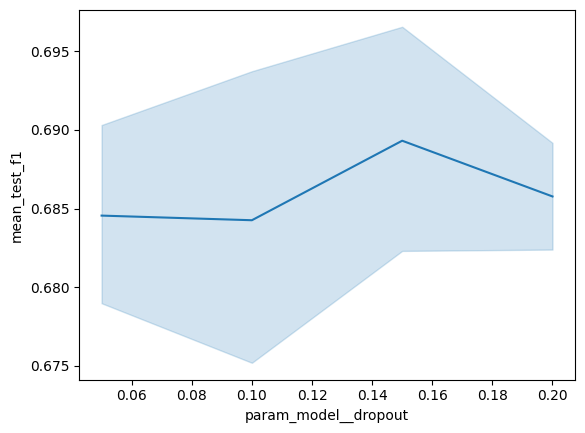

In [63]:
sb.lineplot(data=keras_cv_results_8, x='param_model__dropout', y='mean_test_f1')

In [64]:
keras_scores_test_8.describe()

,accuracy,precision,recall,f1
count,5.000000,5.000000,5.000000,5.000000
mean,0.766502,0.709177,0.680974,0.689370
std,0.009779,0.014894,0.012291,0.012546
min,0.750282,0.692745,0.663358,0.672771
25%,0.764972,0.695203,0.674086,0.679305
50%,0.770362,0.712286,0.686159,0.696166
75%,0.771751,0.718361,0.686565,0.697160
max,0.775141,0.727288,0.694699,0.701448


In [65]:
keras_scores_train_8.describe()

,accuracy,precision,recall,f1
count,5.000000,5.000000,5.000000,5.000000
mean,0.812161,0.776261,0.739766,0.752540
std,0.005745,0.010192,0.009013,0.008996
min,0.803899,0.765223,0.723894,0.736993
25%,0.808475,0.765409,0.741619,0.753510
50%,0.815485,0.780382,0.742794,0.755097
75%,0.815485,0.784393,0.745137,0.757480
max,0.817463,0.785896,0.745384,0.759618


In [67]:
keras_estimators_8

[KerasClassifier(
 	model=<function create_model_5 at 0x00000207014C6D40>
 	build_fn=None
 	warm_start=False
 	random_state=None
 	optimizer=rmsprop
 	loss=None
 	metrics=None
 	batch_size=10
 	validation_batch_size=None
 	verbose=0
 	callbacks=None
 	validation_split=0.0
 	shuffle=True
 	run_eagerly=False
 	epochs=10
 	class_weight=None
 	model__activation=swish
 	model__dropout=0.05
 	model__hidden_neurons1=144
 	model__hidden_neurons2=48
 ),
 KerasClassifier(
 	model=<function create_model_5 at 0x00000207014C6D40>
 	build_fn=None
 	warm_start=False
 	random_state=None
 	optimizer=rmsprop
 	loss=None
 	metrics=None
 	batch_size=10
 	validation_batch_size=None
 	verbose=0
 	callbacks=None
 	validation_split=0.0
 	shuffle=True
 	run_eagerly=False
 	epochs=10
 	class_weight=None
 	model__activation=swish
 	model__dropout=0.15
 	model__hidden_neurons1=144
 	model__hidden_neurons2=48
 ),
 KerasClassifier(
 	model=<function create_model_5 at 0x00000207014C6D40>
 	build_fn=None
 	warm_start

In [33]:
keras_class_param = {
    'batch_size': [10],
    'epochs': [10],
    'model__hidden_neurons1': [144], 
    'model__hidden_neurons2': [48],
    'model__activation': ['swish'],
    'model__dropout': [0.15]
}
keras_model_dropout_estimators_final, keras_model_dropout_scores_train_final, keras_model_dropout_scores_test_final, keras_model_dropout_cv_results_final = train(features, targets, keras_model_dropout, keras_class_param, outer_splits=5, inner_splits=4)

*
*
*
*
*


In [69]:
keras_model_dropout_scores_test_final.describe()

,accuracy,precision,recall,f1
count,5.000000,5.000000,5.000000,5.000000
mean,0.766276,0.706313,0.676214,0.684170
std,0.009078,0.012699,0.014031,0.014870
min,0.750282,0.688598,0.658745,0.667353
25%,0.768362,0.702118,0.666192,0.672455
50%,0.769492,0.703498,0.676685,0.682764
75%,0.770621,0.718499,0.686835,0.696478
max,0.772624,0.718853,0.692611,0.701803


In [71]:
keras_model_dropout_scores_train_final.describe()

,accuracy,precision,recall,f1
count,5.000000,5.000000,5.000000,5.000000
mean,0.813687,0.778276,0.737093,0.750604
std,0.002873,0.004884,0.005720,0.005009
min,0.811017,0.773509,0.728649,0.742881
25%,0.812659,0.774733,0.734237,0.749366
50%,0.812942,0.776749,0.738606,0.750742
75%,0.813224,0.781027,0.741211,0.754680
max,0.818593,0.785363,0.742765,0.755354


In [6]:
def create_model_6(loss='sparse_categorical_crossentropy', activation='swish', hidden_neurons1=125, layers=5, dropout=0.1, reduction_factor=0.5):
    model = Sequential()
    model.add(Input(shape=(36,)))
    model.add(Dense(hidden_neurons1, activation=activation))
    for layer in range(0, layers+1):
        model.add(Dense(int(hidden_neurons1*reduction_factor), activation=activation))
    if(dropout > 0):
        model.add(Dropout(dropout))
    model.add(Dense(3, activation='softmax'))
    model.compile(optimizer=RMSprop(learning_rate=0.0005), loss=loss, metrics=['accuracy'])
    return model
keras_sequential_multilayer = KerasClassifier(model=create_model_6, verbose=0)

In [ ]:
keras_class_param = {
    'batch_size': [10],
    'epochs': [10],
    'model__hidden_neurons1': [250, 500],
    'model__layers': [3, 6, 9],
    'model__reduction_factor': [0.5],
    'model__activation': ['swish', 'relu'],
    'model__dropout':[0.1],
}
keras_estimators_9, keras_scores_train_9, keras_scores_test_9, keras_cv_results_9 = train(features, targets, keras_sequential_multilayer, keras_class_param, outer_splits=5, inner_splits=3)

*
*
*
*
*


<Axes: xlabel='param_model__activation', ylabel='mean_test_f1'>

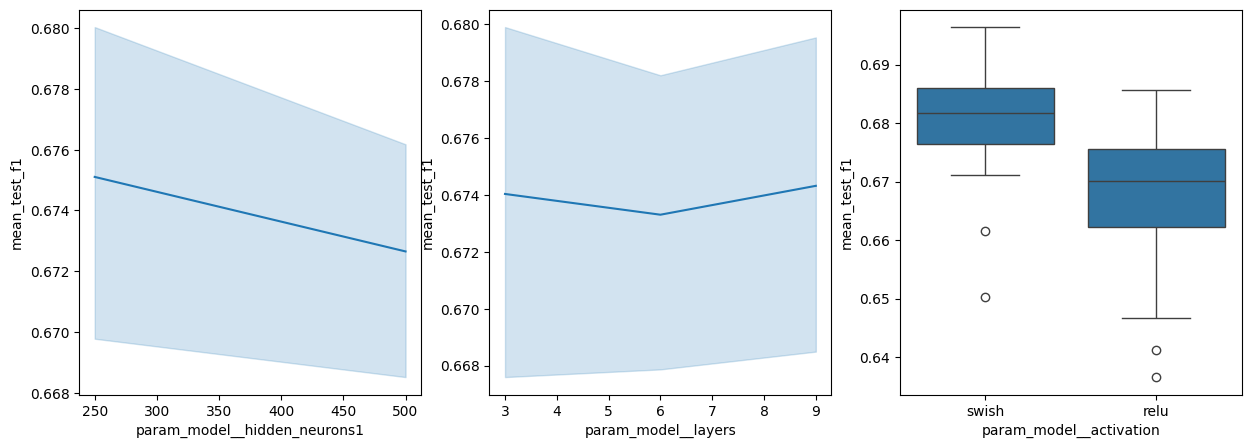

In [22]:
fig, ax = plt.subplots(1,3, figsize=(15,5))
sb.lineplot(data=keras_cv_results_9, x='param_model__hidden_neurons1', y='mean_test_f1', ax=ax[0])
sb.lineplot(data=keras_cv_results_9, x='param_model__layers', y='mean_test_f1', ax=ax[1])
sb.boxplot(data=keras_cv_results_9, x='param_model__activation', y='mean_test_f1', ax=ax[2])

In [26]:
keras_scores_test_9.describe()

,accuracy,precision,recall,f1
count,5.000000,5.000000,5.000000,5.000000
mean,0.767632,0.716010,0.681494,0.690426
std,0.009998,0.012298,0.014294,0.013144
min,0.754802,0.697546,0.669936,0.679314
25%,0.761582,0.714244,0.670570,0.679961
50%,0.768362,0.715423,0.672745,0.683607
75%,0.772624,0.721730,0.696906,0.702572
max,0.780791,0.731106,0.697313,0.706675


In [27]:
keras_scores_train_9.describe()

,accuracy,precision,recall,f1
count,5.000000,5.000000,5.000000,5.000000
mean,0.802272,0.764913,0.724905,0.737203
std,0.005659,0.010824,0.016025,0.015419
min,0.795198,0.750564,0.709399,0.723198
25%,0.799378,0.758666,0.713818,0.724085
50%,0.802204,0.764694,0.717331,0.731341
75%,0.804182,0.773439,0.738612,0.752209
max,0.810398,0.777202,0.745364,0.755183


In [28]:
keras_estimators_9

[KerasClassifier(
 	model=<function create_model_6 at 0x0000020DCA810D60>
 	build_fn=None
 	warm_start=False
 	random_state=None
 	optimizer=rmsprop
 	loss=None
 	metrics=None
 	batch_size=10
 	validation_batch_size=None
 	verbose=0
 	callbacks=None
 	validation_split=0.0
 	shuffle=True
 	run_eagerly=False
 	epochs=10
 	class_weight=None
 	model__activation=swish
 	model__dropout=0.1
 	model__hidden_neurons1=250
 	model__layers=3
 	model__reduction_factor=0.5
 ),
 KerasClassifier(
 	model=<function create_model_6 at 0x0000020DCA810D60>
 	build_fn=None
 	warm_start=False
 	random_state=None
 	optimizer=rmsprop
 	loss=None
 	metrics=None
 	batch_size=10
 	validation_batch_size=None
 	verbose=0
 	callbacks=None
 	validation_split=0.0
 	shuffle=True
 	run_eagerly=False
 	epochs=10
 	class_weight=None
 	model__activation=swish
 	model__dropout=0.1
 	model__hidden_neurons1=250
 	model__layers=3
 	model__reduction_factor=0.5
 ),
 KerasClassifier(
 	model=<function create_model_6 at 0x0000020D

In [7]:
keras_class_param = {
    'batch_size': [10],
    'epochs': [10],
    'model__hidden_neurons1': [250],
    'model__layers': [3, 9, 12],
    'model__reduction_factor': [0.3, 0.5, 0.7],
    'model__activation': ['swish'],
    'model__dropout':[0.1],
}
keras_estimators_10, keras_scores_train_10, keras_scores_test_10, keras_cv_results_10 = train(features, targets, keras_sequential_multilayer, keras_class_param, outer_splits=5, inner_splits=3)

*
*
*
*
*


<Axes: xlabel='param_model__reduction_factor', ylabel='mean_test_f1'>

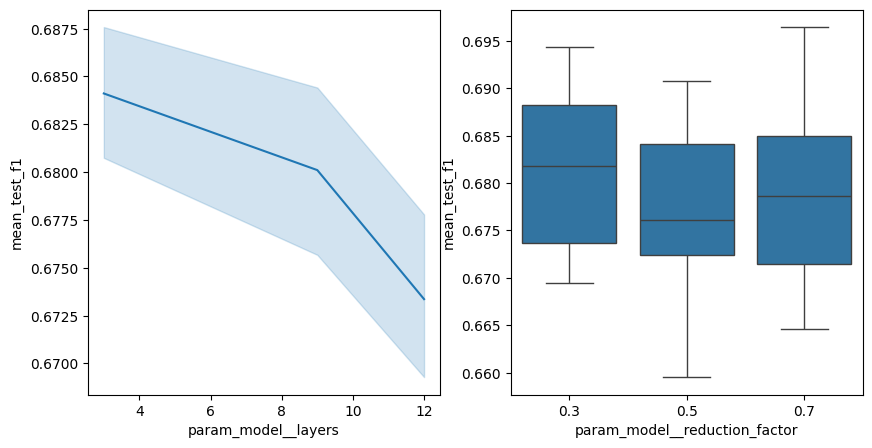

In [9]:
fig, ax = plt.subplots(1,2, figsize=(10,5))
sb.lineplot(data=keras_cv_results_10, x='param_model__layers', y='mean_test_f1', ax=ax[0])
sb.boxplot(data=keras_cv_results_10, x='param_model__reduction_factor', y='mean_test_f1', ax=ax[1])

In [13]:
keras_scores_test_10.describe()

,accuracy,precision,recall,f1
count,5.000000,5.000000,5.000000,5.000000
mean,0.758139,0.700237,0.674500,0.682093
std,0.019565,0.023732,0.020378,0.021114
min,0.725424,0.658788,0.638294,0.644664
25%,0.758192,0.702308,0.679762,0.687666
50%,0.764706,0.710361,0.683399,0.691043
75%,0.764972,0.714626,0.685152,0.691463
max,0.777401,0.715104,0.685894,0.695630


In [12]:
keras_scores_train_10.describe()

,accuracy,precision,recall,f1
count,5.000000,5.000000,5.000000,5.000000
mean,0.801763,0.761556,0.729261,0.740481
std,0.004003,0.007274,0.012661,0.011479
min,0.797400,0.752608,0.714602,0.726913
25%,0.797400,0.758614,0.720387,0.733342
50%,0.804237,0.759143,0.727312,0.737909
75%,0.804465,0.765983,0.738916,0.749435
max,0.805312,0.771430,0.745088,0.754806


In [15]:
keras_estimators_10

[KerasClassifier(
 	model=<function create_model_6 at 0x0000023E05834860>
 	build_fn=None
 	warm_start=False
 	random_state=None
 	optimizer=rmsprop
 	loss=None
 	metrics=None
 	batch_size=10
 	validation_batch_size=None
 	verbose=0
 	callbacks=None
 	validation_split=0.0
 	shuffle=True
 	run_eagerly=False
 	epochs=10
 	class_weight=None
 	model__activation=swish
 	model__dropout=0.1
 	model__hidden_neurons1=250
 	model__layers=3
 	model__reduction_factor=0.3
 ),
 KerasClassifier(
 	model=<function create_model_6 at 0x0000023E05834860>
 	build_fn=None
 	warm_start=False
 	random_state=None
 	optimizer=rmsprop
 	loss=None
 	metrics=None
 	batch_size=10
 	validation_batch_size=None
 	verbose=0
 	callbacks=None
 	validation_split=0.0
 	shuffle=True
 	run_eagerly=False
 	epochs=10
 	class_weight=None
 	model__activation=swish
 	model__dropout=0.1
 	model__hidden_neurons1=250
 	model__layers=9
 	model__reduction_factor=0.7
 ),
 KerasClassifier(
 	model=<function create_model_6 at 0x0000023E

In [17]:
keras_class_param = {
    'batch_size': [10],
    'epochs': [10],
    'model__hidden_neurons1': [75, 125, 250],
    'model__layers': [3, 5],
    'model__reduction_factor': [0.7],
    'model__activation': ['swish'],
    'model__dropout':[0.1],
}
keras_estimators_11, keras_scores_train_11, keras_scores_test_11, keras_cv_results_11 = train(features, targets, keras_sequential_multilayer, keras_class_param, outer_splits=5, inner_splits=3)

*
*
*
*
*


<Axes: xlabel='param_model__hidden_neurons1', ylabel='mean_test_f1'>

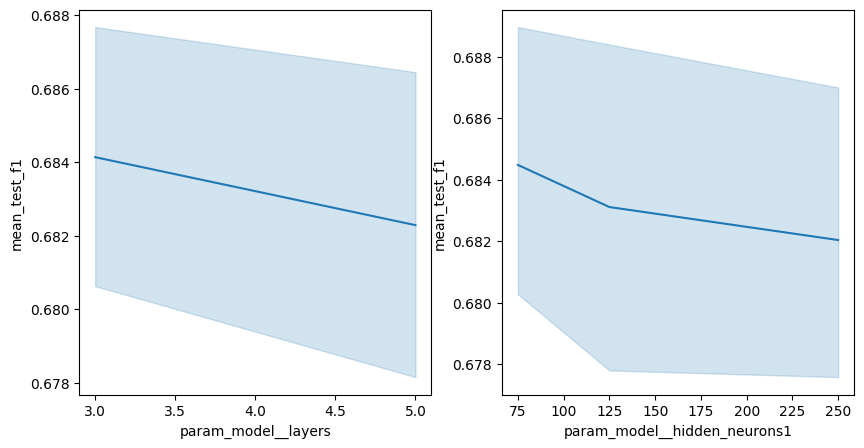

In [18]:
fig, ax = plt.subplots(1,2, figsize=(10,5))
sb.lineplot(data=keras_cv_results_11, x='param_model__layers', y='mean_test_f1', ax=ax[0])
sb.lineplot(data=keras_cv_results_11, x='param_model__hidden_neurons1', y='mean_test_f1', ax=ax[1])

In [19]:
keras_scores_test_11.describe()

,accuracy,precision,recall,f1
count,5.000000,5.000000,5.000000,5.000000
mean,0.762429,0.704383,0.672487,0.678529
std,0.008921,0.014100,0.018719,0.020798
min,0.747738,0.680229,0.650601,0.651741
25%,0.760452,0.704481,0.661672,0.667748
50%,0.766102,0.709185,0.668354,0.675835
75%,0.768362,0.712724,0.683480,0.692390
max,0.769492,0.715298,0.698327,0.704932


In [20]:
keras_scores_train_11.describe()

,accuracy,precision,recall,f1
count,5.000000,5.000000,5.000000,5.000000
mean,0.801876,0.764284,0.722524,0.733262
std,0.005774,0.012121,0.021193,0.020127
min,0.795422,0.751244,0.699435,0.710628
25%,0.798248,0.757725,0.707149,0.719155
50%,0.802204,0.758001,0.716654,0.728895
75%,0.802825,0.776886,0.742470,0.749068
max,0.810681,0.777564,0.746913,0.758563


In [21]:
keras_estimators_11

[KerasClassifier(
 	model=<function create_model_6 at 0x0000023E05834860>
 	build_fn=None
 	warm_start=False
 	random_state=None
 	optimizer=rmsprop
 	loss=None
 	metrics=None
 	batch_size=10
 	validation_batch_size=None
 	verbose=0
 	callbacks=None
 	validation_split=0.0
 	shuffle=True
 	run_eagerly=False
 	epochs=10
 	class_weight=None
 	model__activation=swish
 	model__dropout=0.1
 	model__hidden_neurons1=75
 	model__layers=5
 	model__reduction_factor=0.7
 ),
 KerasClassifier(
 	model=<function create_model_6 at 0x0000023E05834860>
 	build_fn=None
 	warm_start=False
 	random_state=None
 	optimizer=rmsprop
 	loss=None
 	metrics=None
 	batch_size=10
 	validation_batch_size=None
 	verbose=0
 	callbacks=None
 	validation_split=0.0
 	shuffle=True
 	run_eagerly=False
 	epochs=10
 	class_weight=None
 	model__activation=swish
 	model__dropout=0.1
 	model__hidden_neurons1=250
 	model__layers=5
 	model__reduction_factor=0.7
 ),
 KerasClassifier(
 	model=<function create_model_6 at 0x0000023E0

In [22]:
keras_class_param = {
    'batch_size': [10],
    'epochs': [10],
    'model__hidden_neurons1': [75],
    'model__layers': [3],
    'model__reduction_factor': [0.7],
    'model__activation': ['swish'],
    'model__dropout':[0.1],
}
keras_sequential_multilayer_estimators_final, keras_sequential_multilayer_scores_train_final, keras_sequential_multilayer_scores_test_final, keras_sequential_multilayer_cv_results_final = train(features, targets, keras_sequential_multilayer, keras_class_param, outer_splits=5, inner_splits=3)

*
*
*
*
*


In [34]:
keras_sequential_multilayer_scores_test_final.describe()

,accuracy,precision,recall,f1
count,5.000000,5.000000,5.000000,5.000000
mean,0.764467,0.708960,0.689621,0.696164
std,0.009531,0.013133,0.005644,0.006135
min,0.751412,0.691461,0.683829,0.687161
25%,0.760452,0.700607,0.683969,0.692889
50%,0.765837,0.711063,0.690443,0.698391
75%,0.767232,0.717134,0.693373,0.699906
max,0.777401,0.724537,0.696490,0.702475


In [35]:
keras_sequential_multilayer_scores_train_final.describe()

,accuracy,precision,recall,f1
count,5.000000,5.000000,5.000000,5.000000
mean,0.801029,0.757552,0.734485,0.742861
std,0.004699,0.008267,0.011911,0.009673
min,0.793785,0.746257,0.720418,0.729726
25%,0.799096,0.755982,0.723789,0.735539
50%,0.802769,0.756160,0.738627,0.747408
75%,0.803899,0.760224,0.741222,0.750140
max,0.805595,0.769137,0.748367,0.751491


In [36]:
slutt_resultat = pd.DataFrame({
    'Metric': ['Accuracy:','Precision:','Recall:', 'F1:'],
    'Keras Sequential Train': [keras_sequential_scores_train_final['accuracy'].mean(),keras_sequential_scores_train_final['precision'].mean(), keras_sequential_scores_train_final['recall'].mean(), keras_sequential_scores_train_final['f1'].mean()],
    'Keras Sequential Test': [keras_sequential_scores_test_final['accuracy'].mean(),keras_sequential_scores_test_final['precision'].mean(), keras_sequential_scores_test_final['recall'].mean(), keras_sequential_scores_test_final['f1'].mean()],
    'Keras Sequential Dropout Train': [keras_sequential_dropout_scores_train_final['accuracy'].mean(),keras_sequential_dropout_scores_train_final['precision'].mean(), keras_sequential_dropout_scores_train_final['recall'].mean(), keras_sequential_dropout_scores_train_final['f1'].mean()],
    'Keras Sequential Dropout Test': [keras_sequential_dropout_scores_test_final['accuracy'].mean(),keras_sequential_dropout_scores_test_final['precision'].mean(), keras_sequential_dropout_scores_test_final['recall'].mean(), keras_sequential_dropout_scores_test_final['f1'].mean()],
    'Keras Model Train': [keras_model_scores_train_final['accuracy'].mean(),keras_model_scores_train_final['precision'].mean(), keras_model_scores_train_final['recall'].mean(), keras_model_scores_train_final['f1'].mean()],
    'Keras Model Test': [keras_model_scores_test_final['accuracy'].mean(),keras_model_scores_test_final['precision'].mean(), keras_model_scores_test_final['recall'].mean(), keras_model_scores_test_final['f1'].mean()],
    'Keras Model Dropout Train': [keras_model_dropout_scores_train_final['accuracy'].mean(),keras_model_dropout_scores_train_final['precision'].mean(), keras_model_dropout_scores_train_final['recall'].mean(), keras_model_dropout_scores_train_final['f1'].mean()],
    'Keras Model Dropout Test': [keras_model_dropout_scores_test_final['accuracy'].mean(),keras_model_dropout_scores_test_final['precision'].mean(), keras_model_dropout_scores_test_final['recall'].mean(), keras_model_dropout_scores_test_final['f1'].mean()],
    'Keras Sequential Multilayer Train': [keras_sequential_multilayer_scores_train_final['accuracy'].mean(),keras_sequential_multilayer_scores_train_final['precision'].mean(), keras_sequential_multilayer_scores_train_final['recall'].mean(), keras_sequential_multilayer_scores_train_final['f1'].mean()],
    'Keras Sequential Multilayer Test': [keras_sequential_multilayer_scores_test_final['accuracy'].mean(),keras_sequential_multilayer_scores_test_final['precision'].mean(), keras_sequential_multilayer_scores_test_final['recall'].mean(), keras_sequential_multilayer_scores_test_final['f1'].mean()],
    })
slutt_resultat.set_index('Metric', inplace=True)
slutt_resultat

,Keras Sequential Train,Keras Sequential Test,Keras Sequential Dropout Train,Keras Sequential Dropout Test,Keras Model Train,Keras Model Test,Keras Model Dropout Train,Keras Model Dropout Test,Keras Sequential Multilayer Train,Keras Sequential Multilayer Test
Metric,,,,,,,,,,
Accuracy:,0.822163,0.759043,0.801820,0.766502,0.816230,0.762429,0.809448,0.766049,0.801029,0.764467
Precision:,0.790994,0.702305,0.761692,0.709092,0.778839,0.705602,0.773355,0.709059,0.757552,0.708960
Recall:,0.753137,0.677198,0.727530,0.681635,0.752991,0.686812,0.731057,0.678670,0.734485,0.689621
F1:,0.766523,0.685386,0.739470,0.690175,0.763191,0.693611,0.744249,0.687019,0.742861,0.696164
